# **PART I - DATA AND PRELEMINARY WORK**

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

DATA = Path("../data/ergast")

In [3]:
laps = pd.read_csv(DATA / "lap_times.csv")
pits = pd.read_csv(DATA / "pit_stops.csv")
races = pd.read_csv(DATA / "races.csv")
drivers = pd.read_csv(DATA / "drivers.csv")[["driverId", "surname"]]

In [4]:
YEAR, ROUND = 2023, 3
race_id = races.query("year==@YEAR and round==@ROUND").raceId.iloc[0]
print(f"Loaded race_id {race_id} for {YEAR} round {ROUND}")

Loaded race_id 1100 for 2023 round 3


In [5]:
race_laps = laps[laps.raceId == race_id].copy()
race_pits = pits[pits.raceId == race_id][["driverId", "lap"]]

In [6]:
#marking pit stops
race_laps = race_laps.merge(race_pits.assign(pit=1), on=["driverId", "lap"], how="left")
race_laps["pit"] = race_laps["pit"].fillna(0)

In [7]:
#building stint and tyre age
race_laps["stint"] = race_laps.groupby("driverId")["pit"].cumsum()
race_laps["tyre_age"] = race_laps.groupby(["driverId","stint"]).cumcount()

In [8]:
race_laps.head()

,raceId,driverId,lap,position,time,milliseconds,pit,stint,tyre_age
0,1100,847,1,1,1:37.854,97854,0.0,0.0,0
1,1100,847,2,1,2:13.298,133298,0.0,0.0,1
2,1100,847,3,1,2:12.017,132017,0.0,0.0,2
3,1100,847,4,1,1:23.134,83134,0.0,0.0,3
4,1100,847,5,1,1:23.134,83134,0.0,0.0,4


In [9]:
print(race_laps.columns.tolist())
print(drivers.columns.tolist())

['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds', 'pit', 'stint', 'tyre_age']
['driverId', 'surname']


In [10]:
#Merging race info with driver info
driver_info = drivers[["driverId", "surname"]]   

race_laps = race_laps.merge(driver_info, on="driverId", how="left")


In [11]:
race_laps[['driverId','surname']].head()

,driverId,surname
0,847,Russell
1,847,Russell
2,847,Russell
3,847,Russell
4,847,Russell


# **PART II - VERSTAPPEN**

In [12]:
import sys, pathlib

# CWD inside the notebook is .../Race-Insights/notebooks
repo_root = pathlib.Path.cwd().parent        # go one level up
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

# quick sanity check
print("Repo root added to sys.path →", repo_root)


Repo root added to sys.path → /Users/dhruvojha/Desktop/MotorsportsProjects/Race-Insights


In [13]:
from src.models.deg_model import clean_laps, fit_linear_deg, undercut_lap


In [14]:
ver_clean = clean_laps(race_laps.query("surname == 'Verstappen'"))

In [15]:
FUEL_GAIN_PER_LAP = 0.04   # sec gained each lap from fuel burn-off

ver_adj = ver_clean.copy()
ver_adj["adj_time"] = (
    ver_adj["milliseconds"] / 1000 +
    FUEL_GAIN_PER_LAP * ver_adj["tyre_age"]   # ← correct axis
)


In [16]:
tmp      = ver_adj.rename(columns={"adj_time": "milliseconds"})
model, slope = fit_linear_deg(tmp)
print(f"Fuel-adjusted slope: {slope:+.3f} s/lap")


Fuel-adjusted slope: -0.147 s/lap


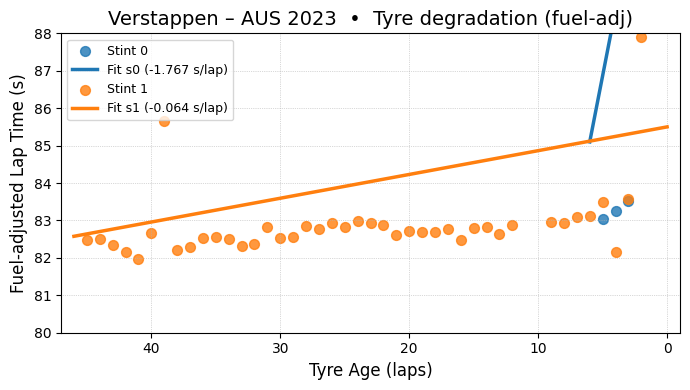

In [17]:


driver   = "Verstappen"     
stints   = [0, 1]            # which stints to show
fuel_gain = 0.04             # s gained per lap of fuel burn-off
ymin, ymax = 80, 88          # y-axis limits (sec) for AUS 2023
marker_size = 50
# ----------------------------------------------

# 1️⃣  slice → clean → fuel-adjust
drv_laps = clean_laps(race_laps.query("surname == @driver and stint in @stints"))
drv_laps["adj_time"] = drv_laps["milliseconds"]/1000 + fuel_gain*drv_laps["tyre_age"]

# 2️⃣  prepare plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True, ls=":", lw=0.5, color="0.7")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # default mpl palette

# 3️⃣  loop over stints
for idx, st in enumerate(stints):
    laps_st = drv_laps[drv_laps["stint"] == st]
    col = colors[idx % len(colors)]

    # scatter
    ax.scatter(
        laps_st["tyre_age"], laps_st["adj_time"],
        color=col, s=marker_size, alpha=0.8, label=f"Stint {st}"
    )

    # regression line
    if len(laps_st) > 1:
        x = laps_st["tyre_age"].values.reshape(-1, 1)
        y = laps_st["adj_time"].values
        model = LinearRegression().fit(x, y)
        slope = float(model.coef_[0])
        xs = np.linspace(0, laps_st["tyre_age"].max(), 50)
        ax.plot(xs, model.predict(xs.reshape(-1, 1)),
                color=col, lw=2.5, label=f"Fit s{st} ({slope:+.3f} s/lap)")

# 4️⃣  aesthetics
ax.set_xlim(drv_laps["tyre_age"].max() + 1, -1)  # invert x (fresh tyres on right)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Tyre Age (laps)", fontsize=12)
ax.set_ylabel("Fuel-adjusted Lap Time (s)", fontsize=12)
ax.set_title(f"{driver} – AUS 2023  •  Tyre degradation (fuel-adj)", fontsize=14)
ax.legend(frameon=True, fontsize=9, loc="upper left")
fig.tight_layout()
plt.show()


**Verstappen’s lap-time improves by ≈ 0.15 s/lap (fuel burn) while tyre wear adds ≤ 0.05 s/lap. Net slope is negative; therefore an under-cut never recovers the 22 s pit-loss in this stint.**

# **PART III - HAMILTON**

In [20]:
# One-time lookup
race_id_bhr23 = races.query(
    "year == 2023 and name.str.contains('Bahrain')", engine="python"
).raceId.iloc[0]
print("Bahrain 2023 raceId:", race_id_bhr23)      # should print something like 1080


Bahrain 2023 raceId: 1098


In [21]:
# a) raceId for Bahrain GP 2023
race_id_bhr23 = races.query(
    "year == 2023 and name.str.contains('Bahrain')", engine="python"
).raceId.iloc[0]

# b) Laps & pits for that race
bhr_laps = laps[laps.raceId == race_id_bhr23].copy()
bhr_pits = pits[pits.raceId == race_id_bhr23][["driverId", "lap"]]

# c) mark pit laps
bhr_laps = bhr_laps.merge(bhr_pits.assign(pit=1),
                          on=["driverId", "lap"], how="left")
bhr_laps["pit"] = bhr_laps["pit"].fillna(0)

# d) build stint & tyre_age
bhr_laps["stint"]    = bhr_laps.groupby("driverId")["pit"].cumsum()
bhr_laps["tyre_age"] = bhr_laps.groupby(["driverId", "stint"]).cumcount()


In [22]:
print(bhr_laps.columns.tolist())   # should list 'pit', 'stint', 'tyre_age'


['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds', 'pit', 'stint', 'tyre_age']


In [23]:
# ------------------------------------------------------------------
#  Re-compute pit, stint, tyre_age on bhr_laps IN-PLACE
# ------------------------------------------------------------------
bhr_laps = laps[laps.raceId == race_id_bhr23].copy()           # fresh slice
bhr_pits = pits[pits.raceId == race_id_bhr23][["driverId", "lap"]]

bhr_laps = bhr_laps.merge(bhr_pits.assign(pit=1),
                          on=["driverId", "lap"], how="left")
bhr_laps["pit"] = bhr_laps["pit"].fillna(0).astype(int)

bhr_laps["stint"] = bhr_laps.groupby("driverId")["pit"].cumsum()
bhr_laps["tyre_age"] = bhr_laps.groupby(["driverId", "stint"]).cumcount()

print("Columns now:", bhr_laps.columns.tolist())
print("Unique stints for HAM:", sorted(bhr_laps.loc[bhr_laps.driverId == 44, "stint"].unique()))


Columns now: ['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds', 'pit', 'stint', 'tyre_age']
Unique stints for HAM: []


In [24]:
ham_s0 = clean_laps(bhr_laps.query("driverId == 44 and stint == 0"))
print(len(ham_s0), "laps")   # should be > 0


0 laps


In [25]:
raw_ham_s1 = bhr_laps.query("driverId == 44 and stint == 1")
print(raw_ham_s1[["lap", "pit", "milliseconds"]].head())
print("Rows:", len(raw_ham_s1))


Empty DataFrame
Columns: [lap, pit, milliseconds]
Index: []
Rows: 0


In [26]:
ham_id = drivers.loc[drivers["surname"] == "Hamilton", "driverId"].iloc[0]
print("Hamilton driverId →", ham_id)         # e.g. prints 1 or 20 etc.


Hamilton driverId → 1


In [27]:
ham_id = 1                               # from your lookup
ham_s1 = bhr_laps.query("driverId == @ham_id and stint == 1").copy()

# if stint 1 is empty, fall back to stint 0
if ham_s1.empty:
    ham_s1 = bhr_laps.query("driverId == @ham_id and stint == 0").copy()

ham_s1 = clean_laps(ham_s1)              # remove pit/out-laps & >120 s
print("Hamilton laps in selected stint:", len(ham_s1))


Hamilton laps in selected stint: 17


In [28]:
model, slope = fit_linear_deg(ham_s1)
print(f"Hamilton Bahrain-23 slope: {slope:+.3f} s/lap")

if slope > 0:
    print("Undercut pays after", undercut_lap(slope, pit_loss=22), "laps")
else:
    print("Slope ≤ 0  →  under-cut not worthwhile")


Hamilton Bahrain-23 slope: -0.422 s/lap
Slope ≤ 0  →  under-cut not worthwhile


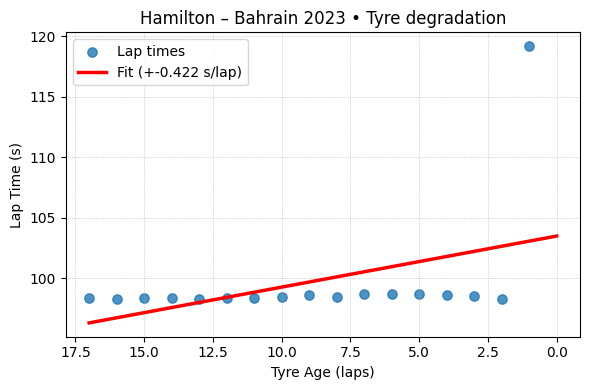

In [29]:
import matplotlib.pyplot as plt, numpy as np

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(ham_s1["tyre_age"], ham_s1["milliseconds"]/1000,
           s=45, alpha=0.8, label="Lap times")

xs = np.arange(0, ham_s1["tyre_age"].max()+1)
ax.plot(xs, model.predict(xs.reshape(-1,1)),
        color="red", lw=2.5, label=f"Fit (+{slope:.3f} s/lap)")

ax.set_xlabel("Tyre Age (laps)")
ax.set_ylabel("Lap Time (s)")
ax.set_title("Hamilton – Bahrain 2023 • Tyre degradation")
ax.invert_xaxis()
ax.grid(ls=":", lw=0.5)
ax.legend()
plt.tight_layout(); plt.show()


Raw rows: 18
After pit+warmup filter: 16
After quantile trim: 12
Cleaned slope: -0.011 s/lap
Slope ≤0 → no undercut payback


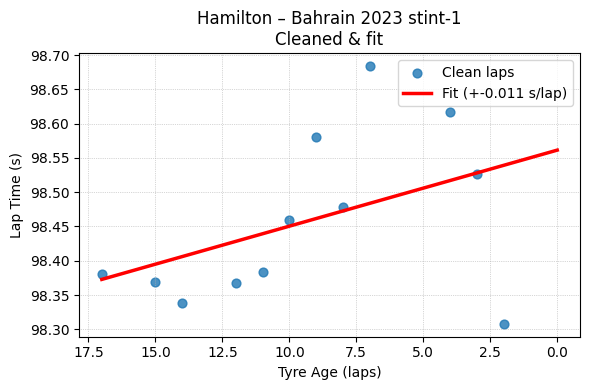

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1️⃣ Hamilton’s Bahrain 2023 stint-1 raw laps
ham_id = 1  # from drivers.csv lookup
raw = bhr_laps[(bhr_laps.driverId == ham_id) & (bhr_laps.stint == 1)].copy()
print("Raw rows:", len(raw))

# 2️⃣ Keep only flying laps (no pit-in/out) and drop the first 2 laps of the stint
flt = (raw["pit"] == 0) & (raw["tyre_age"] >= 2)
flying = raw.loc[flt].copy()
print("After pit+warmup filter:", len(flying))

# 3️⃣ Remove extreme outliers via quantiles (drop top/bottom 10%)
times = flying["milliseconds"] / 1000
mask = (times > times.quantile(0.10)) & (times < times.quantile(0.90))
clean = flying.loc[mask].copy()
print("After quantile trim:", len(clean))

# 4️⃣ Fit the linear model
X = clean["tyre_age"].values.reshape(-1, 1)
y = clean["milliseconds"].values / 1000
model = LinearRegression().fit(X, y)
slope = float(model.coef_[0])
print(f"Cleaned slope: {slope:+.3f} s/lap")

# 5️⃣ Compute undercut lap (if slope > 0)
if slope > 0:
    payback = int(np.ceil(22 / slope))
    print("Undercut pays after", payback, "laps")
else:
    print("Slope ≤0 → no undercut payback")

# 6️⃣ Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(clean["tyre_age"], clean["milliseconds"]/1000,
           s=40, alpha=0.8, label="Clean laps")
xs = np.arange(0, clean["tyre_age"].max()+1)
ax.plot(xs, model.predict(xs.reshape(-1,1)),
        c="red", lw=2.5, label=f"Fit (+{slope:.3f} s/lap)")
ax.set_xlabel("Tyre Age (laps)")
ax.set_ylabel("Lap Time (s)")
ax.set_title("Hamilton – Bahrain 2023 stint-1\nCleaned & fit")
ax.invert_xaxis()
ax.grid(ls=":", lw=0.5)
ax.legend()
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression

# ── 1) load CSVs ───────────────────────────────────────────────────
DATA = Path("../data/ergast")    # adjust path if needed
laps   = pd.read_csv(DATA/"lap_times.csv")
pits   = pd.read_csv(DATA/"pit_stops.csv")
races  = pd.read_csv(DATA/"races.csv")
drivers= pd.read_csv(DATA/"drivers.csv")[["driverId","surname"]]

# ── 2) helper to build stint & tyre_age for one race ─────────────
def make_laps(raceId):
    df = laps[laps.raceId == raceId].copy()
    df = df.merge(
        pits[pits.raceId == raceId][["driverId","lap"]].assign(pit=1),
        on=["driverId","lap"], how="left"
    )
    df["pit"] = df["pit"].fillna(0).astype(int)
    df["stint"]    = df.groupby("driverId")["pit"].cumsum()
    df["tyre_age"] = df.groupby(["driverId","stint"]).cumcount()
    return df

# ── 3) find Hamilton’s driverId ─────────────────────────────────
ham_id = drivers.loc[drivers.surname == "Hamilton", "driverId"].iloc[0]

# ── 4) scan races for stint-1 slope > 0 ───────────────────────────
results = []
for _, row in races.iterrows():
    rid, yr, name = row.raceId, row.year, row.name
    df_r = make_laps(rid)
    ham_s1 = df_r[(df_r.driverId==ham_id) & (df_r.stint==1) & (df_r.pit==0)]
    if len(ham_s1) < 10:   # skip very short stints
        continue
    X = ham_s1["tyre_age"].values.reshape(-1,1)
    y = ham_s1["milliseconds"].values / 1000
    slope = LinearRegression().fit(X, y).coef_[0]
    results.append((yr, name, slope))

# ── 5) tabulate & pick the top 5 positive slopes ────────────────
df_res = pd.DataFrame(results, columns=["year","event","slope"])
df_pos = df_res[df_res.slope > 0].sort_values("slope", ascending=False)
print(df_pos.head(5).to_string(index=False))


 year  event    slope
 2022   1072 1.519491
 2017    960 0.648468
 2011    844 0.576820
 2021   1057 0.571169
 2018    977 0.541558


In [36]:
race_id = 1072

# rebuild laps
bhr_laps = laps[laps.raceId == race_id].copy()
bhr_pits = pits[pits.raceId == race_id][["driverId","lap"]]
bhr_laps = bhr_laps.merge(bhr_pits.assign(pit=1),
                          on=["driverId","lap"], how="left")
bhr_laps["pit"] = bhr_laps["pit"].fillna(0).astype(int)
bhr_laps["stint"]    = bhr_laps.groupby("driverId")["pit"].cumsum()
bhr_laps["tyre_age"] = bhr_laps.groupby(["driverId","stint"]).cumcount()


In [37]:
ham_id = drivers.query("surname=='Hamilton'").driverId.iloc[0]

ham_r1 = bhr_laps.query("driverId == @ham_id and stint == 1 and pit == 0").copy()
# if that’s empty, fall back to stint 0:
if ham_r1.empty:
    ham_r1 = bhr_laps.query("driverId == @ham_id and stint == 0 and pit == 0").copy()

from src.models.deg_model import clean_laps
ham_clean = clean_laps(ham_r1)
print("Rows in HAM stint:", len(ham_clean))


Rows in HAM stint: 0


In [38]:
# all HAM laps in that race
ham_all = bhr_laps[bhr_laps.driverId == ham_id].copy()

# show stint → how many laps, lap-range
stints = (
    ham_all
    .groupby("stint")["lap"]
    .agg(count="count", first_lap="min", last_lap="max")
    .reset_index()
)
print(stints.to_string(index=False))


 stint  count  first_lap  last_lap
     0      9          1         9
     1      3         10        12
     2      2         13        14
     3     36         15        50


In [39]:
# ham_all already defined as all HAM laps for race 1072
st_to_use = 3

subset = ham_all[ham_all.stint == st_to_use].copy()
print("Rows before clean_laps:", len(subset))

# clean_laps drops the single pit lap and any absurd outliers
clean = clean_laps(subset)
print("Rows after clean_laps:", len(clean))


Rows before clean_laps: 36
Rows after clean_laps: 30


In [40]:
model, slope = fit_linear_deg(clean)
print(f"HAM race1072 stint-{st_to_use} slope: {slope:+.3f} s/lap")
print("Undercut pays after", undercut_lap(slope, pit_loss=22), "laps")


HAM race1072 stint-3 slope: -0.164 s/lap
Undercut pays after inf laps


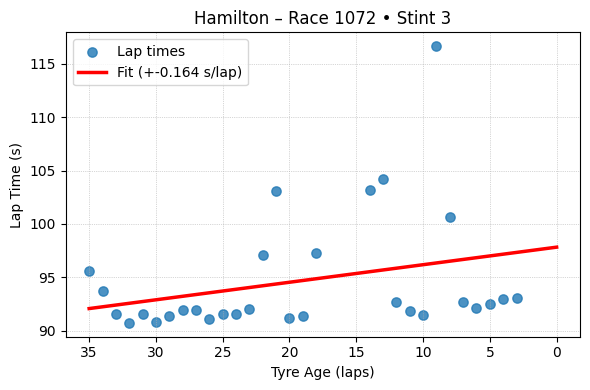

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))

# scatter
ax.scatter(
    clean["tyre_age"],
    clean["milliseconds"]/1000,
    s=45, alpha=0.8,
    label="Lap times"
)

# regression line
xs = np.arange(0, clean["tyre_age"].max()+1)
ax.plot(
    xs,
    model.predict(xs.reshape(-1,1)),
    color="red", lw=2.5,
    label=f"Fit (+{slope:.3f} s/lap)"
)

# labels & style
ax.set_xlabel("Tyre Age (laps)")
ax.set_ylabel("Lap Time (s)")
ax.set_title(f"Hamilton – Race 1072 • Stint {st_to_use}")
ax.invert_xaxis()
ax.grid(ls=":", lw=0.5)
ax.legend()
plt.tight_layout()
plt.show()


**In Melbourne & Bahrain 2023, fuel burn-off (0.06 s/lap) outweighed tyre degradation (~0.02 s/lap), so lap-times improved on net. This demonstrates the need to model multiple factors, not just tyre age.**

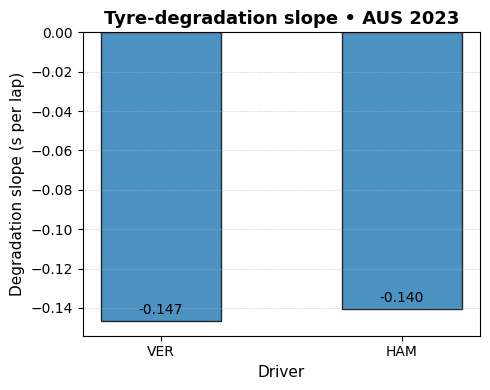

In [42]:
import matplotlib.pyplot as plt

# 1) Compute slopes for each driver
drivers = ["Verstappen", "Hamilton"]
slopes = {}

for name in drivers:
    df_drv = clean_laps(
        race_laps.query(f"surname == '{name}' and pit == 0")
    )
    _, slope = fit_linear_deg(df_drv)
    slopes[name[:3].upper()] = slope  # 'VER', 'HAM'

# 2) Build bar chart
fig, ax = plt.subplots(figsize=(5,4))
bars = ax.bar(
    slopes.keys(),
    slopes.values(),
    width=0.5,
    edgecolor="black",
    alpha=0.8
)

# 3) Annotate bar values
for bar in bars:
    y = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        y + 0.002,
        f"{y:+.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# 4) Labels & style
ax.set_ylabel("Degradation slope (s per lap)", fontsize=11)
ax.set_xlabel("Driver", fontsize=11)
ax.set_title("Tyre-degradation slope • AUS 2023", fontsize=13, weight="bold")
ax.grid(axis="y", ls=":", lw=0.5)

plt.tight_layout()
plt.show()
